In [1]:
#====================================================================== INSTALL PRE-REQS ==================================================================
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
# https://towardsdatascience.com/drug-discovery-with-graph-neural-networks-part-1-1011713185eb
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.models import GraphConvModel 
from rdkit import Chem #Hell of an import
import pandas as pd #Importing panda as "pd"
from rdkit.Chem import AllChem
from rdkit.Chem import Draw #Import function to draw molecules
from itertools import chain
from rdkit.Chem import rdMolDescriptors 
from rdkit import Chem #Hell of an import
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit import RDLogger
from rdkit.Chem.AtomPairs import Pairs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.externals import joblib
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import statistics
#4m 6s

--2021-05-21 23:42:46--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   143MB/s    in 0.6s    

2021-05-21 23:42:46 (143 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda
                         /usr/local

     |████████████████████████████████| 564 kB 26.9 MB/s 
     |████████████████████████████████| 303 kB 38.2 MB/s 
     |████████████████████████████████| 27.4 MB 131 kB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 


deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Building QSPR Models
This section builds 2 QSPR models for predicting the critical miscelle concentration (CMC) of non-ionic surfactants (NIS) using custom QSAR helper functions and a dataset of Non-ionic surfactants and their CMC values collected from literature.

Models:

SeqCMC - Sequential 


In [2]:
NIS = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/ModelData/NonIonicSurfactantsCMC.csv')#Upload model input data (NIS)  
NIS.head(n=3)
#0s

,smiles,mol_name,cmc_NegativeLogM,cmc_mM,temp,Notes,source,ichi_key,record_id,mol_id,article_id
0,CCCCOCCO,NaN,0.01,977.0,25,NaN,Correlation and prediction of critical micelle...,POAOYUHQDCAZBD-UHFFFAOYSA,R45374369,M8709,A130538
1,CC(C)COCCOCCOCCOCCOCCOCCO,NaN,0.05,891.0,25,NaN,Correlation and prediction of critical micelle...,YAXANHFNMATPNL-UHFFFAOYSA,R45374370,M99890287,A130538
2,CCCCOCCOCCOCCOCCOCCOCCO,NaN,0.11,776.0,25,NaN,Correlation and prediction of critical micelle...,LBFDMOHFDLVACT-UHFFFAOYSA,R45374371,M97680887,A130538


In [3]:
#-------- Download Model Helper function for calculating/arranging descriptors and building sequential NN's
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/SeqHelperFun.py 
runfile('/content/SeqHelperFun.py')

#-------- Define fingerprint and descriptors to calculate for input into sequential model
FingerPrintType = 'Fingerprinter.FingerprintMol'

DescriptorList = ['Descriptors.MolWt',  'Descriptors.TPSA',  'Descriptors.NOCount',  'Descriptors.NumHAcceptors',  'Descriptors.NumHDonors',  'Descriptors.NHOHCount',
                  'Descriptors.MolLogP','Descriptors.MolMR',  'Chem.Fragments.fr_C_O',  'Chem.Fragments.fr_ester',  'Chem.Fragments.fr_ether',  'Chem.Fragments.fr_NH1',
                  'Chem.Fragments.fr_NH2','Chem.Fragments.fr_unbrch_alkane',  'Chem.Fragments.fr_amide',  'Descriptors.NumValenceElectrons', 'Descriptors.NumRotatableBonds']

#-------- Calc and return descriptor dataframe
NIS_Descr = CalcDescr_SMIdf(NIS, FingerPrintType, DescriptorList)
#1s

--2021-05-21 23:46:12--  https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/SeqHelperFun.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7890 (7.7K) [text/plain]
Saving to: ‘SeqHelperFun.py’

SeqHelperFun.py     100%[===================>]   7.71K  --.-KB/s    in 0s      

2021-05-21 23:46:12 (77.0 MB/s) - ‘SeqHelperFun.py’ saved [7890/7890]



Epoch 1/500
5/5 [==============================] - 1s 124ms/step - loss: 11.1927 - accuracy: 0.0000e+00 - val_loss: 3.1492 - val_accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 2.7622 - accuracy: 0.0034 - val_loss: 6.2612 - val_accuracy: 0.0000e+00
Epoch 3/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0372 - accuracy: 0.0051 - val_loss: 3.9714 - val_accuracy: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4909 - accuracy: 0.0077 - val_loss: 2.1812 - val_accuracy: 0.0000e+00
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 1.3224 - accuracy: 0.0021 - val_loss: 1.9080 - val_accuracy: 0.0000e+00
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 1.2857 - accuracy: 0.0129 - val_loss: 1.9555 - val_accuracy: 0.0000e+00
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1.0543 - accuracy: 0.0034 - val_loss: 1.7736 - val_accuracy

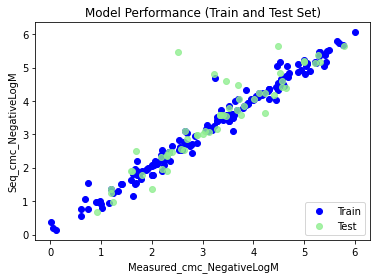

%Error (Test): -2.447 %
%Error (Train): -2.602 %
%Error (Total): 21.013 %

MAE (Test): 9.59 %
MAE (Train): 6.512 %
MAE (Total): 24.992 %

RMS (Test): 0.5593
RMS (Train): 0.221
RMS (Total): 0.3393


,smiles,Mol,Measured_cmc_NegativeLogM,Seq_cmc_NegativeLogM,Percent_Error,Abs_error
0,CCCCOCCO,<rdkit.Chem.rdchem.Mol object at 0x7ff9871574e0>,0.01000,0.371668,3616.676831,3616.68% error
1,CC(C)COCCOCCOCCOCCOCCOCCO,<rdkit.Chem.rdchem.Mol object at 0x7ff987157490>,0.05000,0.210164,320.327574,320.33% error
2,CCCCOCCOCCOCCOCCOCCOCCO,<rdkit.Chem.rdchem.Mol object at 0x7ff987157580>,0.11000,0.136691,24.264996,24.26% error
3,CCCCCCS(=O)CCCO,<rdkit.Chem.rdchem.Mol object at 0x7ff9871575d0>,0.60206,0.779416,29.458128,29.46% error
4,CCCCCCS(=O)CCO,<rdkit.Chem.rdchem.Mol object at 0x7ff987157620>,0.60206,0.566892,-5.841224,5.84% error


In [4]:
#============================== Build Sequential QSPR model to predict CMC Non-ionic Surfs ==============================
Descriptors_train, Descriptors_test, Property_train, Property_test=PreProcess_SMIdf(NIS_Descr,  #_________________________________________ PRE-PROCESS/SPLIT DATA
                                                                                    property_id = 'cmc_NegativeLogM', 
                                                                                    TestSize = 0.2) 

SeqCMC = Sequential([Dense(units= 5, input_dim= Descriptors_train.shape[1], activation='relu'),#2nd layer (first hidden layer)#___________ BUILD MODEL
                     Dense(units= 10 ,  activation='relu' ), # 3rd layer (No shape needs to be specified)
                     Dense(units= 1 ,  activation='linear' )]) # Output layer

SeqCMC.compile(optimizer= SGD(lr=0.01,  momentum=0.9,  nesterov=True),  loss= 'mean_squared_error',  metrics= ['accuracy']) #_____________ COMPILE MODEL  
SeqCMC_ModHist = SeqCMC.fit(Descriptors_train,  Property_train,  validation_split = 0.1,    batch_size=32,    epochs=500) #_______________ TRAIN MODEL
NIS_SeqCMC = Seq_Model_performance(NIS_Descr, property_id = 'cmc_NegativeLogM', model = SeqCMC)#__________________________________________ PLOT/CALC MODEL PERFORMANCE
NIS_SeqCMC.head()
#45s

--2021-05-21 23:46:42--  https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/GCNNhelperFun.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5353 (5.2K) [text/plain]
Saving to: ‘GCNNhelperFun.py’

GCNNhelperFun.py    100%[===================>]   5.23K  --.-KB/s    in 0s      

2021-05-21 23:46:42 (74.1 MB/s) - ‘GCNNhelperFun.py’ saved [5353/5353]

--2021-05-21 23:46:43--  https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/ModelData/NonIonicSurfactantsCMC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting r

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(260,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(260, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of m

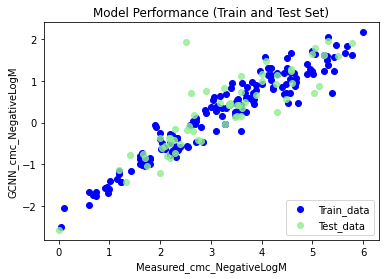

{'pearson_r2_score': 0.9188141490256206}
{'pearson_r2_score': 0.7815274920382786}
Total MAE: 34.514 %


,smiles,Measured_cmc_NegativeLogM,GCNN_cmc_NegativeLogM,Percent_Error
0,CCCCOCCO,0.01000,-0.360,-3700.00
1,CC(C)COCCOCCOCCOCCOCCOCCO,0.05000,-0.243,-586.00
2,CCCCOCCOCCOCCOCCOCCOCCO,0.11000,0.362,229.09
3,CCCCCCS(=O)CCCO,0.60206,0.897,48.99
4,CCCCCCS(=O)CCO,0.60206,0.460,-23.60


In [5]:
#-------- Download Model Helper function for building Graph Convolutional NNs
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/GCNNhelperFun.py
runfile('/content/GCNNhelperFun.py')
#Build Graph Convolutional QSPR model to predict CMC Non-ionic Surfs
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/ModelData/NonIonicSurfactantsCMC.csv
dataset_file= "NonIonicSurfactantsCMC.csv"

gcnnCMC, NIS_gcnnCMC = GCNN_Model_Creator(dataset_file,    #___ PREPROCESS, BUILD, COMPILE, TRAIN, Plot and Calculate GCNN Model Performance
                                          task_name ="cmc_NegativeLogM",  
                                          smiles_field = "smiles", 
                                          epochs = 124,  
                                          batchSize = 50 )
NIS_gcnnCMC.head()
#35s

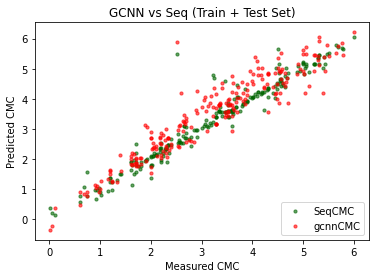

MAE SeqCMC: 24.991762360058168
MAE gcnnCMC: 34.514125560538155


Mean Residual SeqCMC: 0.1811379810160807
Mean Residual gcnnCMC: 0.40627381282511205


,smiles,CMC_Measured_NegativeLogM,CMC_seq,CMC_gcnn,Percent_error_Seq,Percent_error_gcnn,SeqCMC_residuals,gcnnCMC_residuals,Mol
218,CCCCCCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO,5.680000,5.733451,5.768,0.941045,1.55,0.053451,0.088000,<rdkit.Chem.rdchem.Mol object at 0x7ff987163990>
219,CCCCCCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCO,5.770000,5.673113,5.868,-1.679145,1.70,-0.096887,0.098000,<rdkit.Chem.rdchem.Mol object at 0x7ff9871639e0>
220,CCCCCCCCCCCCCCCCOCCOCCOCCOCCOCCOCCO,5.780000,5.642944,5.470,-2.371214,-5.36,-0.137056,-0.310000,<rdkit.Chem.rdchem.Mol object at 0x7ff987163a30>
221,CCCCCCCCCCCCC\C=C\[C@@H](O)[C@@H](N)CO,6.004365,6.052817,6.213,0.806955,3.47,0.048453,0.208635,<rdkit.Chem.rdchem.Mol object at 0x7ff987163a80>
222,CC(CCC(=O)N(CCCNC(=O)C(O)C(O)C(O)C(O)CO)CCCNC(...,2.537600,2.831677,2.444,11.588802,-3.69,0.294077,-0.093600,<rdkit.Chem.rdchem.Mol object at 0x7ff987163ad0>


In [6]:
#Merge Model Performance dataframes and plot their performances on top of each other
NISwModPredictions = NIS_SeqCMC.merge(NIS_gcnnCMC, left_on='smiles', right_on='smiles')
NISwModPred = pd.DataFrame({'smiles':                NISwModPredictions.smiles,
                               'CMC_Measured_NegativeLogM':          NISwModPredictions.Measured_cmc_NegativeLogM_x, 
                               'CMC_seq':               NISwModPredictions.Seq_cmc_NegativeLogM, 
                               'CMC_gcnn':              NISwModPredictions.GCNN_cmc_NegativeLogM, 
                               'Percent_error_Seq':     NISwModPredictions.Percent_Error_x, 
                               'Percent_error_gcnn':    NISwModPredictions.Percent_Error_y,
                               'SeqCMC_residuals':  NISwModPredictions.Seq_cmc_NegativeLogM - NISwModPredictions.Measured_cmc_NegativeLogM_x, 
                               'gcnnCMC_residuals': NISwModPredictions.GCNN_cmc_NegativeLogM - NISwModPredictions.Measured_cmc_NegativeLogM_x,
                               'Mol':               NISwModPredictions.Mol})

plt.scatter(NISwModPred.CMC_Measured_NegativeLogM,  NISwModPred.CMC_seq,   label = 'SeqCMC',    c='darkgreen', s = 10, alpha=.6) #Plotting training data measured vs predicted
plt.scatter(NISwModPred.CMC_Measured_NegativeLogM,  NISwModPred.CMC_gcnn,  c='red', label='gcnnCMC', s = 10, alpha=.6) #Adding test data measured vs predicted
plt.title('GCNN vs Seq (Train + Test Set)')
plt.xlabel("Measured CMC")
plt.ylabel("Predicted CMC")
plt.legend(loc=4)
plt.show()

print("MAE SeqCMC:", sum([abs(val) for val in NISwModPred.Percent_error_Seq])/len(NISwModPred) )
print("MAE gcnnCMC:", sum([abs(val) for val in NISwModPred.Percent_error_gcnn])/len(NISwModPred) )
print("\n\nMean Residual SeqCMC:", abs(NISwModPred.SeqCMC_residuals).mean()   )     
print("Mean Residual gcnnCMC:", abs(NISwModPred.gcnnCMC_residuals).mean()   )     

NISwModPred.tail()
#0s

Okay so the max absolute error for gcnnCMC is much larger than that of SeqCMC, BUT the max residual for SeqCMC is much larger than that of gcnnCMC. Logarithmically, this ends difference is massive

# Candidate Generation
This section generates molecular candidates by reacting biomass-derived precursors with various cheap/easily-accessible reactants via 1-4 step synthetic routes.


In [7]:
#-------- Download rxn_smarts functions to help generate candidates
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/rxnSMARTS/RxnFun3.py #CHANGE
runfile('/content/RxnFun3.py')

BioPre = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/BioMassPrecursors.csv') # Biomass Precursor Data
BioPre["Mol"] = [Chem.MolFromSmiles(SMILE) for SMILE in BioPre.smiles] # Convert to mol format

NR = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/Nucleophilic_Reactants.csv') # Nucleophilic Reactant Data
NR["Mol"] = [Chem.MolFromSmiles(SMILE) for SMILE in NR.smiles] # N = Nucleophiles

ER = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/Electrophilic_reactants.csv')# Electrophilic Reactant Data
ER["Mol"] = [Chem.MolFromSmiles(SMILE) for SMILE in ER.smiles]
#1s

--2021-05-21 23:47:13--  https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/rxnSMARTS/RxnFun3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11034 (11K) [text/plain]
Saving to: ‘RxnFun3.py’

RxnFun3.py          100%[===================>]  10.78K  --.-KB/s    in 0s      

2021-05-21 23:47:13 (68.5 MB/s) - ‘RxnFun3.py’ saved [11034/11034]



Number of unique candidates:   41979


                                                    Mol  ...               rxnSeq
1255  <rdkit.Chem.rdchem.Mol object at 0x7ff97d198670>  ...  BioPre_famRed_ER_NR
1256  <rdkit.Chem.rdchem.Mol object at 0x7ff97d1986c0>  ...  BioPre_famRed_ER_NR
1257  <rdkit.Chem.rdchem.Mol object at 0x7ff97d198710>  ...  BioPre_famRed_ER_NR
1258  <rdkit.Chem.rdchem.Mol object at 0x7ff97d198760>  ...  BioPre_famRed_ER_NR
1259  <rdkit.Chem.rdchem.Mol object at 0x7ff97d1987b0>  ...  BioPre_famRed_ER_NR

[5 rows x 3 columns]


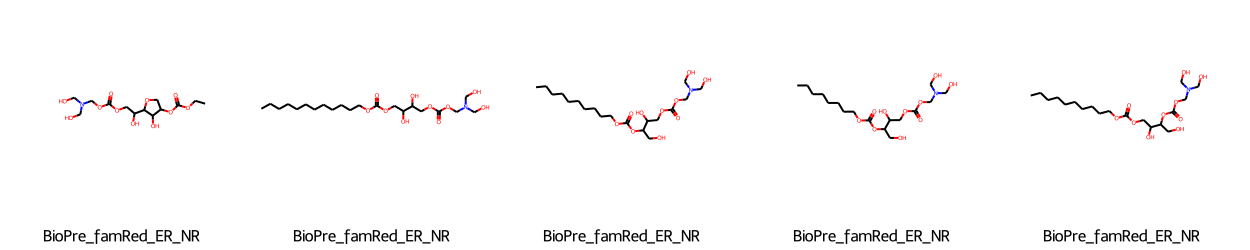

In [8]:
#-------- Candidate Generation 
BioPre_ER = Nuc_ring_opening(ER, BioPre)#___________________________________________ Epoxide/CC5 opening (via BioPre)
BioPre_ER_ER = Nuc_ring_opening(ER, BioPre_ER)#_________________________________________ Epoxide/CC5 opening (via ER_BP)

BioPre_ep = Epoxidation(BioPre)#____________________________________________________ Alkene epoxidations
BioPre_ep_NR = Nuc_ring_opening(BioPre_ep,  NR  )#______________________________________ Epoxide opening (via NR)

BioPre_ep_NR4 = NHOH_limit(BioPre_ep_NR, limit_to= 4)
BioPre_ep_NR4_ER = Nuc_ring_opening(ER, BioPre_ep_NR4 )#_________ Epoxide/CC5 opening (via BioPre_ep_NR w/limited NHOH functionality)

NR4 = NHOH_limit(NR, limit_to= 4)
BioPre_ep_NR4_ER_NR4 = Nuc_ring_opening(BioPre_ep_NR4_ER, NR4)#___ Epoxide/CC5 opening (via NR w/limited NHOH functionality)

BioPre_ep_cc5 = Cyclic_Carbonation(BioPre_ep)#__________________________________________ Cyclic carbonation (CC5)
BioPre_ep_cc5_NR = Nuc_ring_opening(BioPre_ep_cc5, NR)#_________________________________ CC5 opening (via NR)
BioPre_ep_cc5_NR_ER = Nuc_ring_opening(ER, BioPre_ep_cc5_NR)#_________________________________ CC5 opening (via NR)

BioPre_tNR = fame_transesterifications(BioPre, NR) #________________________________ FAME Transesterifications (via NR)
BioPre_tNR_ER = Nuc_ring_opening(ER, BioPre_tNR) #________________________________ Epoxide/CC5 opening (via BioPre_tNR)

BioPre_tER = fame_transesterifications(BioPre, ER) #________________________________ FAME Transesterifications (via OH groups on ER)
BioPre_tER_NR = Nuc_ring_opening(BioPre_tER, NR) #______________________________________ Epoxide/CC5 opening (via NR)

BioPre_famRed = fame_reduction(BioPre) #______________________________________________________________________ FAME Reductions
BioPre_famRed_ER = Nuc_ring_opening(ER, BioPre_famRed) # Using reduced FAME's to open up Electrophilic reactants
BioPre_famRed_ER_NR = Nuc_ring_opening(BioPre_famRed_ER, NR) 

#-------- Combining Generated Candidates
GenMols_SMIdf_total= pd.concat([BioPre_ep_NR4_ER_NR4, BioPre_ep_NR4_ER, BioPre_ep_NR4, BioPre_ep_cc5_NR, BioPre_ep_cc5_NR_ER,BioPre_ER_ER, BioPre_ER,BioPre_tNR, BioPre_tNR_ER, BioPre_tER_NR, BioPre_famRed_ER, BioPre_famRed_ER_NR ])
GenMols_SMIdf = GenMols_SMIdf_total[GenMols_SMIdf_total.duplicated(subset=['smiles']) == False]
print("Number of unique candidates:  ",len(GenMols_SMIdf))
print("\n\n",GenMols_SMIdf.tail() )
Draw.MolsToGridImage(GenMols_SMIdf.Mol.tail(),    molsPerRow = 5, subImgSize = (250,250) ,   legends = [str(val) for val in GenMols_SMIdf.rxnSeq.tail().values])
#31s

# Applicability Domain (filter candidates)
"SimAD.py" has custom defined functions for selecting compounds in a dataset that fall within the AD of a model.

In [9]:
#-------- Determine average distance from Training Dataset for each molecule in the Training Dataset
import itertools
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Applicability%20Domain/SimAD.py 
runfile('/content/SimAD.py')

NISwModPred["Dist"] =  Dist2Model_APfp(NISwModPred, NISwModPred)

print('Range of Dist (TrainMols to TrainSet):',round(NISwModPred.Dist.min(),4), '-',round(NISwModPred.Dist.max(),4))
print('Dist Median (TrainMols to TrainSet):' , round(NISwModPred.Dist.median(),4), '\nDist Mean (TrainMols to TrainSet):' , round(NISwModPred.Dist.mean(),4))
print('Dist StDev (TrainMols to TrainSet):' ,round(statistics.pstdev(NISwModPred.Dist),4))
#0s

--2021-05-21 23:47:37--  https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Applicability%20Domain/SimAD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5309 (5.2K) [text/plain]
Saving to: ‘SimAD.py’

SimAD.py            100%[===================>]   5.18K  --.-KB/s    in 0s      

2021-05-21 23:47:37 (50.0 MB/s) - ‘SimAD.py’ saved [5309/5309]

Range of Dist (TrainMols to TrainSet): 0.1329 - 0.4529
Dist Median (TrainMols to TrainSet): 0.3604 
Dist Mean (TrainMols to TrainSet): 0.3463
Dist StDev (TrainMols to TrainSet): 0.0634


In [10]:
GenMols_SMIdf['Dist'] = Dist2Model_APfp(GenMols_SMIdf, NISwModPred)

print('Range of Dist (GenMols to TrainSet):',round(GenMols_SMIdf.Dist.min(),4), '-',round(GenMols_SMIdf.Dist.max(),4))
print('Dist Median (GenMols to TrainSet):' , round(GenMols_SMIdf.Dist.median(),4), '\nDist Mean (GenMols to TrainSet):' , round(GenMols_SMIdf.Dist.mean(),4))
print('Dist StDev (GenMols to TrainSet):' ,round(statistics.pstdev(GenMols_SMIdf.Dist),4))
#
GM_d2m = GenMols_SMIdf.sort_values(by = "Dist", ascending=False)

Range of Dist (GenMols to TrainSet): 0.0437 - 0.4517
Dist Median (GenMols to TrainSet): 0.2998 
Dist Mean (GenMols to TrainSet): 0.2997
Dist StDev (GenMols to TrainSet): 0.0456


__main__:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


__main__:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

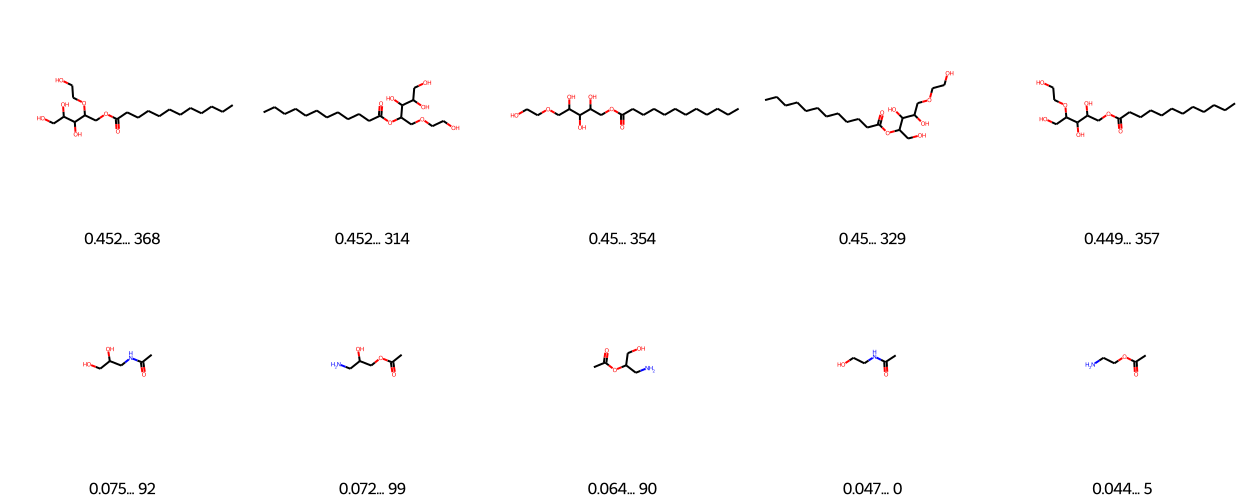

In [11]:
GM_d2m = GM_d2m.reset_index()
GM_d2m_head = GM_d2m.head(n=5)
GM_d2m_head["Dist_str"] = [str(val) for val in [round(val,3) for val in GM_d2m_head.Dist]]
GM_d2m_head["index_str"] = [str(val) for val in GM_d2m_head['index']]
GM_d2m_tail = GM_d2m.tail(n=5)
GM_d2m_tail["Dist_str"] = [str(val) for val in [round(val,3) for val in GM_d2m_tail.Dist]]
GM_d2m_tail["index_str"] = [str(val) for val in GM_d2m_tail['index']]
GM_d2m_head_tail = GM_d2m_head.append(GM_d2m_tail)
Draw.MolsToGridImage(GM_d2m_head_tail.Mol,                    molsPerRow = 5, subImgSize = (250,250),                     legends = [str(val) for val in GM_d2m_head_tail[['Dist_str', 'index_str']].agg('... '.join, axis=1)])

In [12]:
GM_TopSim = GM_d2m[GM_d2m.Dist>0.42]
GM_TopSim

,index,Mol,smiles,rxnSeq,Dist
0,368,<rdkit.Chem.rdchem.Mol object at 0x7ff97d3c7260>,CCCCCCCCCCCC(=O)OCC(OCCO)C(O)C(O)CO,BioPre_tNR_ER,0.451709
1,314,<rdkit.Chem.rdchem.Mol object at 0x7ff97d30b6c0>,CCCCCCCCCCCC(=O)OC(COCCO)C(O)C(O)CO,BioPre_tNR_ER,0.451528
2,354,<rdkit.Chem.rdchem.Mol object at 0x7ff97d313760>,CCCCCCCCCCCC(=O)OCC(O)C(O)C(O)COCCO,BioPre_tNR_ER,0.450467
3,329,<rdkit.Chem.rdchem.Mol object at 0x7ff97d313530>,CCCCCCCCCCCC(=O)OC(CO)C(O)C(O)COCCO,BioPre_tNR_ER,0.449541
4,357,<rdkit.Chem.rdchem.Mol object at 0x7ff97d313850>,CCCCCCCCCCCC(=O)OCC(O)C(O)C(CO)OCCO,BioPre_tNR_ER,0.449182
...,...,...,...,...,...
296,151,<rdkit.Chem.rdchem.Mol object at 0x7ff97d2505d0>,CCCCCCCCCC(=O)OC(COC(CO)CO)C(O)CO,BioPre_tNR_ER,0.420189
297,1003,<rdkit.Chem.rdchem.Mol object at 0x7ff97d257760>,CCCCCCCCCCCC(=O)OC(CN)C(O)C(O)C(O)COCC(O)CO,BioPre_tNR_ER,0.420153
298,153,<rdkit.Chem.rdchem.Mol object at 0x7ff97d262f80>,CCCCCCCCCC(=O)OCC(O)COC(CO)C1OCC(O)C1O,BioPre_tER_NR,0.420131
299,53,<rdkit.Chem.rdchem.Mol object at 0x7ff97d359760>,CCCCCCCCCCCC(=O)OC(C(O)CN)C(O)C(O)CO,BioPre_tNR,0.420106


# Apply QSPR Models

In [13]:
#======================== Sequential Model and predict property for newly generated molecules using Sequential Model
GM_TopSim_Descr = CalcDescr_SMIdf(GM_TopSim, FingerPrintType, DescriptorList )
GM_TopSim_Seq = Seq_Model_Predict(GM_TopSim_Descr,  property_id = 'cmc_NegativeLogM',  model =  SeqCMC)


#======================== Graph Conv Model ==========================
#----- Predict property for newly generated molecules using GCNN Model


GM_TopSim_Seq_GCNN = GraphCNN_Model_Predict_2(dataset=  GM_TopSim_Seq,
                                        training_dataset = NIS,
                                        model = gcnnCMC,
                                        task_name = 'cmc_NegativeLogM',
                                        smiles_field = "smiles")

GM_TopSim_Seq_GCNN.head()
#print(GM_TopSim_GCNN.head())


__main__:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
__main__:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,index,Mol,smiles,rxnSeq,Dist,Descriptors,Seq_cmc_NegativeLogM,cmc_NegativeLogM,GCNN_cmc_NegativeLogM
0,368,<rdkit.Chem.rdchem.Mol object at 0x7ff97d1487b0>,CCCCCCCCCCCC(=O)OCC(OCCO)C(O)C(O)CO,BioPre_tNR_ER,0.451709,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",4.474161,1.892963,3.796
1,314,<rdkit.Chem.rdchem.Mol object at 0x7ff97df2af30>,CCCCCCCCCCCC(=O)OC(COCCO)C(O)C(O)CO,BioPre_tNR_ER,0.451528,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",5.591526,0.981298,3.582
2,354,<rdkit.Chem.rdchem.Mol object at 0x7ff97d149d50>,CCCCCCCCCCCC(=O)OCC(O)C(O)C(O)COCCO,BioPre_tNR_ER,0.450467,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",5.591526,1.027198,3.649
3,329,<rdkit.Chem.rdchem.Mol object at 0x7ff97d149e90>,CCCCCCCCCCCC(=O)OC(CO)C(O)C(O)COCCO,BioPre_tNR_ER,0.449541,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",5.591526,4.258116,3.330
4,357,<rdkit.Chem.rdchem.Mol object at 0x7ff97d149350>,CCCCCCCCCCCC(=O)OCC(O)C(O)C(CO)OCCO,BioPre_tNR_ER,0.449182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",4.474161,2.981807,3.259


/root/miniconda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


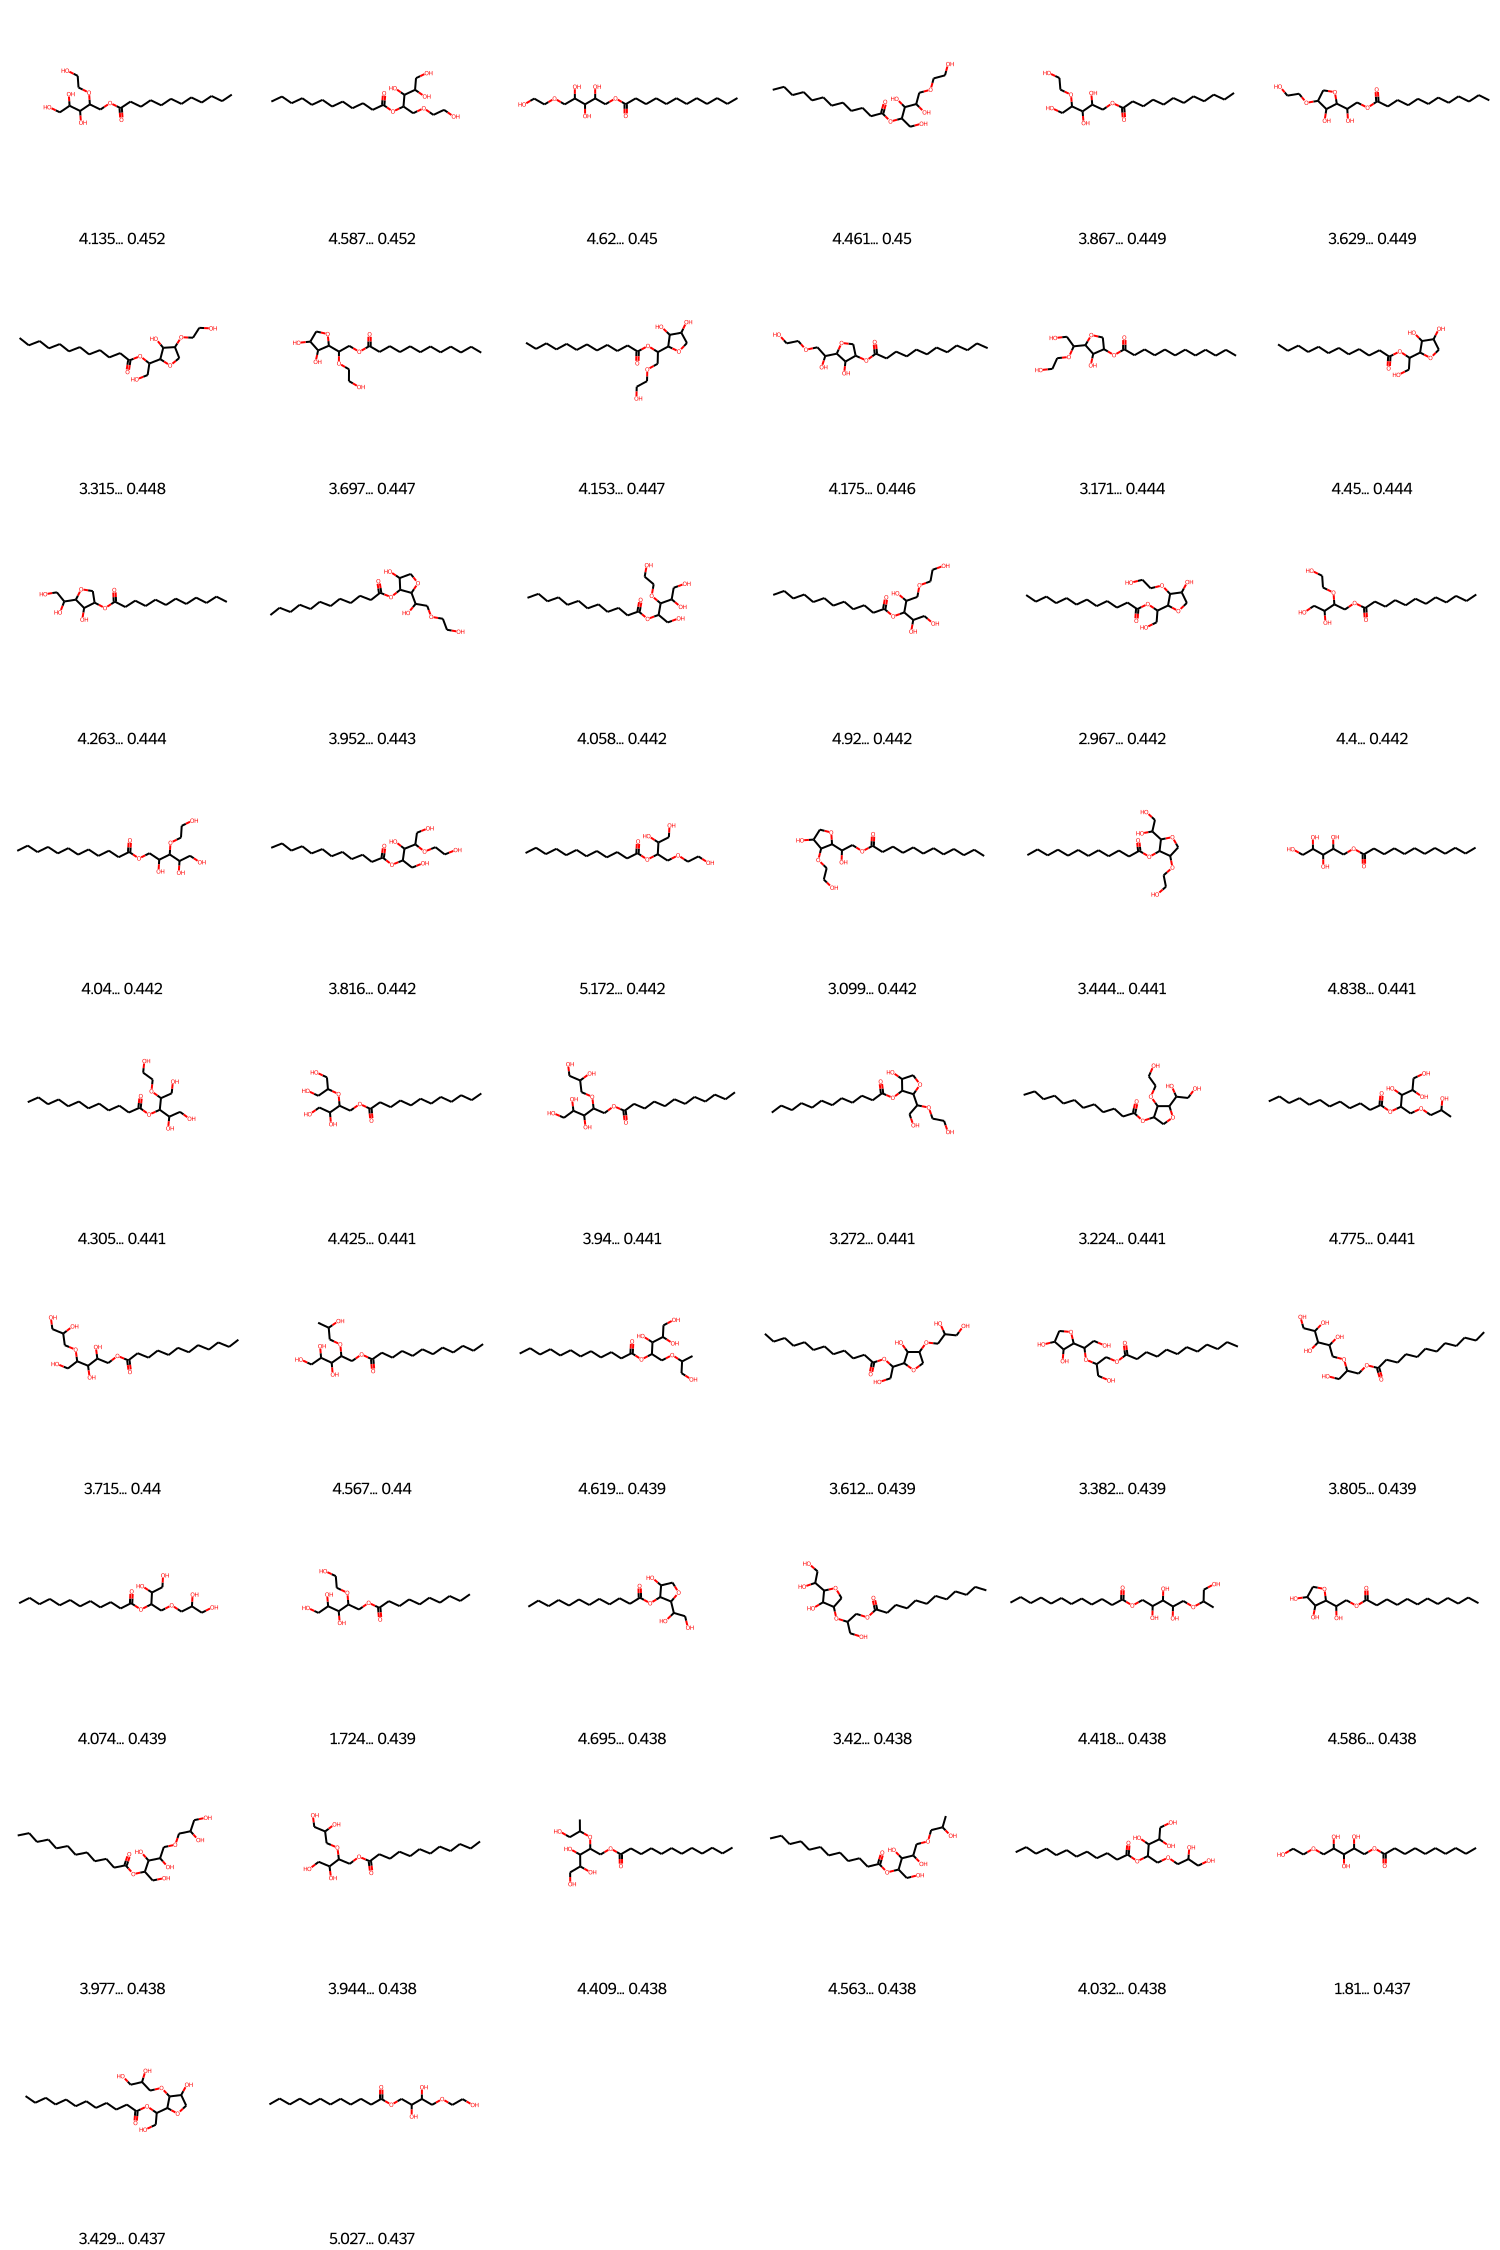

In [14]:
 
#GenMols_pred = GenMols_Seq.merge(GenMols_GCNN, left_on='smiles', right_on='smiles')#____________________________________________ Merge model predictions

#GenMols_predictions = pd.DataFrame({"smiles":GenMols_pred.smiles, #_____________________________________________________________ Remake df using relavent columns 
#"Dist2TrainSet": round(GenMols_pred.Dist2TrainSet, 3),  "IF_AD": GenMols_pred.IsoForest_AD,  
#"Seq_CMC": round( GenMols_pred.Predicted_cmc_NegativeLogM_x, 3), "GCNN_CMC":  round(GenMols_pred.Predicted_cmc_NegativeLogM_y, 3),
#"consensus_CMC": round((GenMols_pred.Predicted_cmc_NegativeLogM_y + GenMols_pred.Predicted_cmc_NegativeLogM_x)/2, 3),  "Mol": GenMols_pred.Mol })


GenMols_pred_sorted = GM_TopSim_Seq_GCNN.sort_values(by = 'Dist', ascending= False)#__________________________________ Sort df

GenMols_pred_sorted['consensus_CMC']  = round((GenMols_pred_sorted.Seq_cmc_NegativeLogM + GenMols_pred_sorted.GCNN_cmc_NegativeLogM)/2, 3)
GenMols_pred_sorted['consensus_str'] = [str(val) for val in GenMols_pred_sorted['consensus_CMC']]
GenMols_pred_sorted['Dist_str'] = [str(round(val,3)) for val in GenMols_pred_sorted['Dist']]




Draw.MolsToGridImage(GenMols_pred_sorted.Mol,
                    molsPerRow = 6, subImgSize = (250,250), 
                    legends = [str(val) for val in GenMols_pred_sorted[['consensus_str', 'Dist_str']].agg('... '.join, axis=1)])

In [15]:
"""
========================================================== E  N  D ==========================================================
"""

'\n========================================================== E  N  D ==========================================================\n'

In [16]:
"""def FP_Similarity_Filter(GenMols, TrainMols, RangeTrain2Compare ):
  def FP_Similarity(GenMols, TrainMols, TrainMol2Compare ):
    GenMols = GenMols.append([TrainMols[TrainMol2Compare:(TrainMol2Compare+1)]], ignore_index=True)
    Tmol2compare = len(GenMols)-1
    GenMols["fps"]= [Chem.RDKFingerprint(mol) for mol in GenMols.Mol]
    GenMols['Dist'] = [DataStructs.FingerprintSimilarity(GenMols.fps[Tmol2compare],fps) for fps in GenMols.fps]
    GenMols['Tmol'] = ["{}{}".format('T', TrainMol2Compare) for dist in GenMols['Dist'] ]
    GenMols['Dist_Str'] = [str(round(dist,4)) for dist in GenMols.Dist]
    GenMols['Distance_str'] = GenMols[['Tmol', 'Dist_Str']].agg(' Similarity:  '.join, axis=1)
    GenMolsSimilarity = GenMols.drop(['Tmol', 'Dist_Str'], axis=1)
    return GenMolsSimilarity
  allTrainingMols = [FP_Similarity(GenMols = GenMols,   TrainMols = TrainMols,    TrainMol2Compare = mol) for mol in RangeTrain2Compare ]
  allTrainingMols = pd.concat(allTrainingMols)
  #allTrainingMols_sorted = allTrainingMols.sort_values(by='Dist', ascending=False)
  Distsummary = allTrainingMols.groupby('smiles', as_index=False).mean()#['Avg_Dist2_Tmols'].mean()
  Dist_sum_merged = Distsummary.merge(GenMols, left_on='smiles', right_on='smiles')  
  Dist_sum_merged_sorted = Dist_sum_merged.sort_values(by = 'Dist', ascending=False)
  return Distsummary, allTrainingMols, Dist_sum_merged_sorted
#____________________________________________________________________________________________________________________________________________________________________________
def Dist2Model(GeneratedMols, TrainingMols, TopMolsToCompare):
  DistSum_T, allTrainMols_T, TrainMols_Dist = FP_Similarity_Filter(GenMols = TrainingMols ,TrainMols = TrainingMols,RangeTrain2Compare = range(0,(len(TrainingMols)-1)) )
  print('Range of Dist (TrainMols to TrainSet):',round(TrainMols_Dist.Dist.min(),4), '-',round(TrainMols_Dist.Dist.max(),4))
  print('Dist Median (TrainMols to TrainSet):' , round(TrainMols_Dist.Dist.median(),4), '\nDist Mean (TrainMols to TrainSet):' , round(TrainMols_Dist.Dist.mean(),4))
  print('Dist StDev (TrainMols to TrainSet):' ,round(statistics.pstdev(TrainMols_Dist.Dist),4))
  TrainMols_Dist_sorted = TrainMols_Dist.sort_values(by =  "Dist", ascending = False)
  TrainMols_Dist_sorted_Top = TrainMols_Dist_sorted[0:TopMolsToCompare]
  DistSum_T, allTrainMols_T, TrainMols_Dist_Top = FP_Similarity_Filter(GenMols = TrainingMols ,TrainMols = TrainMols_Dist_sorted_Top,RangeTrain2Compare = range(0,(len(TrainingMols)-1)) )
  print('\nRange of Dist (Top_Train_Mols to TrainSet):',round(TrainMols_Dist_Top.Dist.min(),4), '-',round(TrainMols_Dist_Top.Dist.max(),4))
  print('Dist Median (Top_Train_Mols to TrainSet):' , round(TrainMols_Dist_Top.Dist.median(),4), '\nDist Mean (TrainMols to TrainSet):' , round(TrainMols_Dist_Top.Dist.mean(),4))
  print('Dist StDev (Top_Train_Mols to TrainSet):' ,round(statistics.pstdev(TrainMols_Dist_Top.Dist),4))
  Distsummary, allTrainingMols, GenMols_IF_Dist = FP_Similarity_Filter(GenMols = GeneratedMols,TrainMols = TrainMols_Dist_sorted_Top,RangeTrain2Compare = range(0, len(GeneratedMols))  )
  GenMols_IF_Dist = pd.DataFrame({"smiles": GenMols_IF_Dist.smiles, "IsoForest_AD":GenMols_IF_Dist.GenMols_AD_x, "Dist2TrainSet": GenMols_IF_Dist.Dist, "Mol":GenMols_IF_Dist.Mol })
  return GenMols_IF_Dist, TrainMols_Dist"""

'def FP_Similarity_Filter(GenMols, TrainMols, RangeTrain2Compare ):\n  def FP_Similarity(GenMols, TrainMols, TrainMol2Compare ):\n    GenMols = GenMols.append([TrainMols[TrainMol2Compare:(TrainMol2Compare+1)]], ignore_index=True)\n    Tmol2compare = len(GenMols)-1\n    GenMols["fps"]= [Chem.RDKFingerprint(mol) for mol in GenMols.Mol]\n    GenMols[\'Dist\'] = [DataStructs.FingerprintSimilarity(GenMols.fps[Tmol2compare],fps) for fps in GenMols.fps]\n    GenMols[\'Tmol\'] = ["{}{}".format(\'T\', TrainMol2Compare) for dist in GenMols[\'Dist\'] ]\n    GenMols[\'Dist_Str\'] = [str(round(dist,4)) for dist in GenMols.Dist]\n    GenMols[\'Distance_str\'] = GenMols[[\'Tmol\', \'Dist_Str\']].agg(\' Similarity:  \'.join, axis=1)\n    GenMolsSimilarity = GenMols.drop([\'Tmol\', \'Dist_Str\'], axis=1)\n    return GenMolsSimilarity\n  allTrainingMols = [FP_Similarity(GenMols = GenMols,   TrainMols = TrainMols,    TrainMol2Compare = mol) for mol in RangeTrain2Compare ]\n  allTrainingMols = pd.concat(a

In [17]:
"""#----- Phytol RXN Pathway 1 
#phy_1 = Epoxidation(phy) #____(phy ---> phy_1)
#phy_1_a = Nuc_ring_opening(phy_1, NR, return_format= 'Mol') #____(phy_1 ---> phy_1_a)
#phy_1_a_i = Nuc_ring_opening(ER, NHOH_limit(phy_1_a, 3), return_format= 'Mol') #____(phy_1_a ---> phy_1_a_i)
#phy_1_a_ii = Nuc_ring_opening(ER,   NHOH_limit(phy_1_a_i, 3)   , return_format= 'Mol') #____(phy_1_a_i ---> phy_1_a_ii)
#phy_1_b  = Nuc_ring_opening(phy_1, ER_OH, return_format= 'Mol') # #____(phy_1 ---> phy_1_b)
#phy_1_b_i = Nuc_ring_opening(phy_1_b,    NR,       return_format = 'Mol')#____(phy_1_b ---> phy_1_b_i)
#phy_1_c = Cyclic_Carbonation(phy_1) #____(phy_1 ---> phy_1_c)
#phy_1_c_i = Nuc_ring_opening(phy_1_c, NR, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_i)
#----- Phytol RXN Pathway 2 
#phy_2 = Nuc_ring_opening( ER_tot,  phy, return_format = 'Mol')#____(phy ---> phy_2)
#phy_2_a = Nuc_ring_opening( phy_2,  NR, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#----- COMBINING Unique Products from Phytol RXN Pathway 1&2 (phy_1 & phy_2) 
all_phy_products_list = [x for l in [phy_1_a,    phy_1_a_i,   phy_1_a_ii,   phy_1_b,   phy_1_b_i,    phy_1_c_i,  phy_2,        phy_2_a] for x in l] #,phy_1_b_ii #phy_1_a_ii, phy_2_b phy_1_c_ii
all_phy_products_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_list] #Mol to Smiles
all_phy_products_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_products_smiles)] #Smiles to unique Mol
all_phy_products_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_unique] #Unique Mol to unique Smiles

#----- FAME RXN Pathway 1 
fam_1 = fame_transesterifications(fam, NR, return_format= 'Mol') #____(fam ---> fam_1)
fam_1_a = Nuc_ring_opening(ER_tot, NHOH_limit(fam_1, 4), return_format= 'Mol')
#----- FAME RXN Pathway 2 
fam_2  = fame_transesterifications(fam, ER_OH, return_format= 'Mol') #____(fam ---> fam_2)
fam_2_a = Nuc_ring_opening(fam_2,  NR, return_format = 'Mol')#____(fam_2 ---> fam_2_a)
fam_2_a_i = Nuc_ring_opening(ER_tot,  NHOH_limit(fam_2_a, 3 ), return_format = 'Mol')
fam_2_b  = fame_transesterifications(fam, NHOH_limit(fam_2,3), return_format= 'Mol') #____(fam ---> fam_2)
#----- FAME RXN Pathway 3
fam_3 = fame_reduction(fam)
fam_3_a = Nuc_ring_opening(ER_tot, fam_3, return_format= 'Mol')
fam_3_a_i = Nuc_ring_opening(ER, fam_3_a, return_format= 'Mol')
fam_3_a_ii = Nuc_ring_opening(ER, fam_3_a_i, return_format= 'Mol')
fam_3_b = Nuc_ring_opening( fam_3_a,  NR, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#----- COMBINING all fam_1 & fam_2 &fam_3 products 
all_fam_list = [x for l in [fam_1, fam_1_a, fam_2_a, fam_2_a_i, fam_2_b,fam_3_a,fam_3_a_i, fam_3_a_ii,fam_3_b  ] for x in l] #
all_fam_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_list] #Mol to Smiles
all_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_fam_smiles)] #Smiles to unique Mol
all_fam_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_unique] #Unique Mol to unique Smiles


#----- COMBINING ALL RXN PATH PRODUCTS (FAME + Phytols) 
all_phy_fam_smiles_list = [x for l in [all_fam_smiles_unique, all_phy_products_smiles_unique ] for x in l]
all_phy_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_fam_smiles_list)] #Smiles to unique Mol
generated_phytolFAME_surfs = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_fam_unique] #Unique Mol to unique Smiles
GenPHY_SMIdf = pd.DataFrame({'smiles': all_phy_products_smiles_unique})
GenFAM_SMIdf = pd.DataFrame({'smiles': all_fam_smiles_unique})
print('\n\nUnique Phytol products:',len(all_phy_products_smiles_unique))
print('Unique FAME products:',len(all_fam_smiles_unique))
print('Total unique products:',len(generated_phytolFAME_surfs))
GenMols_SMIdf = pd.DataFrame({'smiles': generated_phytolFAME_surfs}) # Turn generated smiles into dataframe
GenMols_SMIdf.head()"""

"#----- Phytol RXN Pathway 1 \n#phy_1 = Epoxidation(phy) #____(phy ---> phy_1)\n#phy_1_a = Nuc_ring_opening(phy_1, NR, return_format= 'Mol') #____(phy_1 ---> phy_1_a)\n#phy_1_a_i = Nuc_ring_opening(ER, NHOH_limit(phy_1_a, 3), return_format= 'Mol') #____(phy_1_a ---> phy_1_a_i)\n#phy_1_a_ii = Nuc_ring_opening(ER,   NHOH_limit(phy_1_a_i, 3)   , return_format= 'Mol') #____(phy_1_a_i ---> phy_1_a_ii)\n#phy_1_b  = Nuc_ring_opening(phy_1, ER_OH, return_format= 'Mol') # #____(phy_1 ---> phy_1_b)\n#phy_1_b_i = Nuc_ring_opening(phy_1_b,    NR,       return_format = 'Mol')#____(phy_1_b ---> phy_1_b_i)\n#phy_1_c = Cyclic_Carbonation(phy_1) #____(phy_1 ---> phy_1_c)\n#phy_1_c_i = Nuc_ring_opening(phy_1_c, NR, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_i)\n#----- Phytol RXN Pathway 2 \n#phy_2 = Nuc_ring_opening( ER_tot,  phy, return_format = 'Mol')#____(phy ---> phy_2)\n#phy_2_a = Nuc_ring_opening( phy_2,  NR, return_format = 'Mol')#____(phy_2 ---> phy_2_a)\n#----- COMBINING Unique Products f

In [18]:
"""#-------- Download rxn_smarts functions to help generate candidates
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/rxnSMARTS/RxnFun.py #CHANGE
runfile('/content/RxnFun.py')

#----- Upload Nucleophilic Reactant Data
Nucleophilic_Reactants = pd.read_csv('https://github.com/MarcusVaughnHarris/Data/main/LabReactants/Nucleophilic_Reactants.csv') 
NR = [Chem.MolFromSmiles(SMILE) for SMILE in Nucleophilic_Reactants.smiles] # N = Nucleophiles


#----- Upload Biomass Precursor Data
BioMass_precursors = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/BioMassPrecursors.csv') #Using Panda function to read the dataset
BioMass_precursor_mols = [Chem.MolFromSmiles(SMILE) for SMILE in BioMass_precursors.smiles] # Convert to mol format
#----- Split precursors by type (phytol-based and fatty acid methyl ester-based)
fam = FG_split(BioMass_precursor_mols, Chem.MolFromSmarts('[#6]-[#6](-[#8])=O'), keep_group = True) # FAME precursors ('fam')
phy = FG_split(BioMass_precursor_mols, Chem.MolFromSmarts('[OH]'), keep_group = True) # Phytol precursors ('phy')

#----- Upload Electrophilic Reactant Data
Electrophilic_reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/Electrophilic_reactants.csv')
ER_tot = [Chem.MolFromSmiles(SMILE) for SMILE in Electrophilic_reactants.smiles]
#----- Split Electrophilic Reactants by type ( and fatty acid methyl ester-based)
ER_OH = FG_split(ER_tot, Chem.MolFromSmarts('[OH]'), keep_group = True)# Electrophilic reactants WITH Nucleophilic OH group ('ER_OH')
ER = FG_split(ER_tot, Chem.MolFromSmarts('[OH]'), keep_group = False) # Electrophilic reactants W/OUT Nucleophilic OH group ('E')"""

"#-------- Download rxn_smarts functions to help generate candidates\n!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/rxnSMARTS/RxnFun.py #CHANGE\nrunfile('/content/RxnFun.py')\n\n#----- Upload Nucleophilic Reactant Data\nNucleophilic_Reactants = pd.read_csv('https://github.com/MarcusVaughnHarris/Data/main/LabReactants/Nucleophilic_Reactants.csv') \nNR = [Chem.MolFromSmiles(SMILE) for SMILE in Nucleophilic_Reactants.smiles] # N = Nucleophiles\n\n\n#----- Upload Biomass Precursor Data\nBioMass_precursors = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/BioMassPrecursors.csv') #Using Panda function to read the dataset\nBioMass_precursor_mols = [Chem.MolFromSmiles(SMILE) for SMILE in BioMass_precursors.smiles] # Convert to mol format\n#----- Split precursors by type (phytol-based and fatty acid methyl ester-based)\nfam = FG_split(BioMass_precursor_mols, Chem.MolFromSmarts('[#6]-[#6](-[#8])=O'), keep_group = True) # FAME precur

In [19]:
"""def GraphCNN_Model_Predict_2(dataset,  training_dataset, model, task_name, smiles_field = "smiles"):

  dataset[task_name]= (np.random.rand( dataset.shape[0]))*max(training_dataset[task_name])
  dataset.to_csv('/content/GM_TopSim.csv')
  dataset_file = '/content/GM_TopSim.csv'

  loader = dc.data.CSVLoader(tasks=[task_name],  smiles_field="smiles", featurizer=dc.feat.ConvMolFeaturizer())
  data = loader.featurize(dataset_file) # Featurizing the dataset with ConvMolFeaturizer
  normalizer = dc.trans.NormalizationTransformer(transform_y=True, dataset=data,move_mean=True)
  struc_data = normalizer.transform(data)
  cmc_pred = model.predict_on_batch(struc_data.X)
  cmc_pred= normalizer.untransform(cmc_pred)
  cmc_pred_list = [x for l in cmc_pred for x in l]
  
  predicted_prop_id = "{}{}".format('GCNN_',task_name)

  train_smiles = list(struc_data.ids)
  len(train_smiles)
  model_measured_pred = pd.DataFrame({'smiles': train_smiles})
  model_measured_pred[predicted_prop_id] = cmc_pred_list #Adding predicted CMC to original Dataframe

  model_measured_pred[predicted_prop_id] = round(model_measured_pred[predicted_prop_id], 3)

  GenMols_pred = dataset.merge(model_measured_pred, left_on='smiles', right_on='smiles')#____________________________________________ Merge model predictions
  return GenMols_pred"""

'def GraphCNN_Model_Predict_2(dataset,  training_dataset, model, task_name, smiles_field = "smiles"):\n\n  dataset[task_name]= (np.random.rand( dataset.shape[0]))*max(training_dataset[task_name])\n  dataset.to_csv(\'/content/GM_TopSim.csv\')\n  dataset_file = \'/content/GM_TopSim.csv\'\n\n  loader = dc.data.CSVLoader(tasks=[task_name],  smiles_field="smiles", featurizer=dc.feat.ConvMolFeaturizer())\n  data = loader.featurize(dataset_file) # Featurizing the dataset with ConvMolFeaturizer\n  normalizer = dc.trans.NormalizationTransformer(transform_y=True, dataset=data,move_mean=True)\n  struc_data = normalizer.transform(data)\n  cmc_pred = model.predict_on_batch(struc_data.X)\n  cmc_pred= normalizer.untransform(cmc_pred)\n  cmc_pred_list = [x for l in cmc_pred for x in l]\n  \n  predicted_prop_id = "{}{}".format(\'GCNN_\',task_name)\n\n  train_smiles = list(struc_data.ids)\n  len(train_smiles)\n  model_measured_pred = pd.DataFrame({\'smiles\': train_smiles})\n  model_measured_pred[predic